In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import pylab as plt
%matplotlib inline
import torchvision.utils as vutils
import glob
import torch.nn.functional as F
import seaborn as sns
import copy
import scipy
import os
from torchvision import transforms

from sklearn import manifold, decomposition

from matplotlib import offsetbox

from PIL import Image

In [2]:
import sys
sys.path.append('../')
import models
import models.mnist
from data import get_loaders
from utils import DictWrapper
import utils

In [3]:
# sns.set_color_codes('husl')
sns.set_palette('husl')
sns.set()

In [4]:
%load_ext autoreload
%autoreload 1

In [5]:
%aimport log_plotter
from log_plotter import get_run_names, get_data, get_data_pth, plot_smooth, plot_tag, plot_runs_and_tags, get_legend, plot_smooth_o1

In [53]:
def get_samples(run_dir, gfname, prefix, nsamples=20, sz=28, seed=123):
    gpath = os.path.join(run_dir, '%s.pth.tar' % gfname)
    data = torch.load(gpath)
    assign_i = data['assign']
    loss_i = data['loss']
    total_dist = data['total_dist']
    opt, dataset = data['opt'], data['dataset']
    opt = utils.DictWrapper(opt)
    np.random.seed(seed)

    opt.cuda = not opt.no_cuda and torch.cuda.is_available()

    train_loader, test_loader, train_test_loader = get_loaders(opt)
    if dataset == 'train_test':
        dataset = train_test_loader.dataset
    elif dataset == 'test':
        dataset = test_loader.dataset
    dataset.ds.transform = transforms.Compose([
        transforms.Resize(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        ])

    import models
    model_path = os.path.join(opt.resume, opt.ckpt_name)
    checkpoint = torch.load(os.path.join(prefix, model_path),
                            map_location='cpu')
    model = models.init_model(opt)
    model.load_state_dict(checkpoint['model'])

    _, counts = np.unique(assign_i, return_counts=True)

    nclusters = int(assign_i.max()+1)

    lc = np.zeros((nclusters, ))
    for i in range(nclusters):
        idx, _ = np.where(assign_i == i)
        if len(idx) > 0:
            lc[i] = loss_i[idx].mean()
    cids = np.argsort(lc)
    print('Total loss: %.4f' % (loss_i.mean()))
    # print('Total accuracy: %.2f%%' % ((correct*100.).mean()))
    print('Total dist: %.4f' % total_dist.sum())
    print('')
    X = []
    y = []
    G = []
    cls = []
    correct = []
    for c in range(nclusters):
        i = cids[c]
        idx, _ = np.where(assign_i == i)
        print('Cluster %d, size: %d' % (i, len(idx)))
        if len(idx) == 0:
            continue
        print('Cluster %d, loss: %.4f' % (i, loss_i[idx].mean()))
        np.random.shuffle(idx)
        for j in range(min(len(idx), nsamples)):
            xi, yi = dataset[idx[j]][0], dataset[idx[j]][1]
            X += [xi]
            y += [yi]
            model.zero_grad()
            output = model(xi.unsqueeze(0))
            pred = output.max(1)[1].item()
            correct += [yi == pred]
            import torch.nn.functional as F
            loss = F.nll_loss(output, torch.tensor(yi).long().unsqueeze(0))
            G += [torch.cat(
                [x.flatten()
                 for x in torch.autograd.grad(loss, model.parameters())])]
            cls += [c]
    X = torch.stack(X)
    y = torch.tensor(y).long()
    G = torch.stack(G)
    return X, y, G, np.array(cls)

In [63]:
def get_embedding(logdir, k=50, nsamples=20):
    X, y, G, c = get_samples(logdir, 'bgluster_test', '/u/faghri/dmom/code', nsamples=nsamples)

    print(G.shape)
    print('> SVD')

    # G_pca = decomposition.TruncatedSVD(n_components=50).fit_transform(G)
    # U, S, Vh = scipy.linalg.svd(G-G.mean(0), full_matrices=False, compute_uv=True)
    # G_svd = np.dot(U[:,:k], np.diag(S[:k]))
    from sklearn import decomposition
    pca = decomposition.PCA(n_components=k)
    G_svd = pca.fit_transform(G)

    print(G_svd.shape)
    return X, y, c, G_svd

In [20]:
def plot_embedding(Xi, X, y, c, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    palette = sns.color_palette("husl", c.max()+1)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(int(y[i])),
                 color=palette[c[i]],
                 fontdict={'weight': 'bold', 'size': 9})

    if False:
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-2:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.array(Image.fromarray(Xi[i].numpy()).resize((14,14))), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [9]:
def plot_tsne(X, y, c, G_svd, ppls):
    G_tsne = []
    for ppl in ppls:
        tsne = manifold.TSNE(n_components=2, perplexity=ppl, init='pca', random_state=0)
        G_tsne += [tsne.fit_transform(G_svd)]
        plt.figure()
        plot_embedding(X[:,0], G_tsne[-1], y, c)
    return G_tsne

# Color is cluster number

# tsne

Total loss: 0.1359
Total dist: 174.8723

Cluster 1, size: 3185
Cluster 1, loss: 0.0017
Cluster 4, size: 1352
Cluster 4, loss: 0.0097
Cluster 7, size: 1016
Cluster 7, loss: 0.0145
Cluster 3, size: 867
Cluster 3, loss: 0.0324
Cluster 2, size: 832
Cluster 2, loss: 0.0370
Cluster 0, size: 601
Cluster 0, loss: 0.1126
Cluster 8, size: 965
Cluster 8, loss: 0.2116
Cluster 6, size: 383
Cluster 6, loss: 0.8183
Cluster 5, size: 394
Cluster 5, loss: 0.8374
Cluster 9, size: 405
Cluster 9, loss: 0.8673
torch.Size([200, 2265602])
> SVD
(200, 50)


<Figure size 432x288 with 0 Axes>

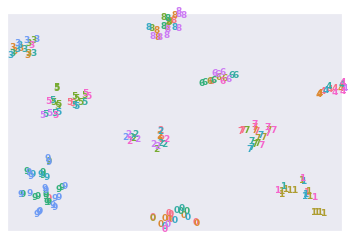

<Figure size 432x288 with 0 Axes>

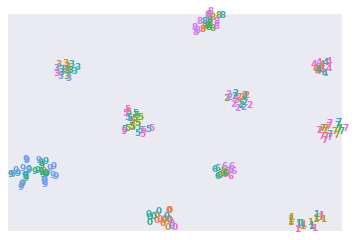

<Figure size 432x288 with 0 Axes>

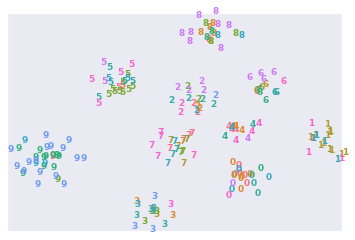

<Figure size 432x288 with 0 Axes>

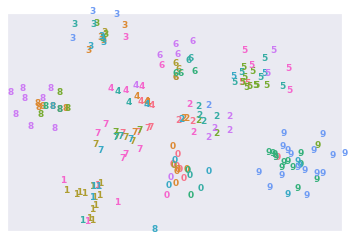

<Figure size 432x288 with 0 Axes>

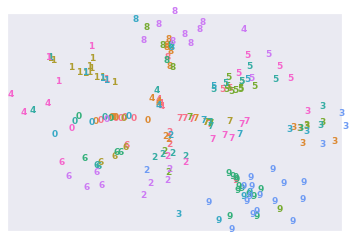

<Figure size 432x288 with 0 Axes>

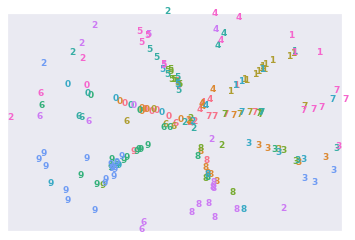

In [58]:
logdir = '/u/faghri/dmom/code/runs/mnist/bgluster,epoch_1/'
X, y, c, G_svd = get_embedding(logdir)
G_tsne = plot_tsne(X, y, c, G_svd, [2, 5, 30, 50, 70, 100])

Total loss: 0.0303
Total dist: 17.5651

Cluster 0, size: 5047
Cluster 0, loss: 0.0003
Cluster 1, size: 653
Cluster 1, loss: 0.0023
Cluster 5, size: 612
Cluster 5, loss: 0.0066
Cluster 8, size: 477
Cluster 8, loss: 0.0080
Cluster 7, size: 964
Cluster 7, loss: 0.0171
Cluster 2, size: 1534
Cluster 2, loss: 0.0234
Cluster 6, size: 243
Cluster 6, loss: 0.2243
Cluster 3, size: 151
Cluster 3, loss: 0.3261
Cluster 9, size: 157
Cluster 9, loss: 0.4150
Cluster 4, size: 162
Cluster 4, loss: 0.4384
torch.Size([200, 2265602])
> SVD
(200, 50)


<Figure size 432x288 with 0 Axes>

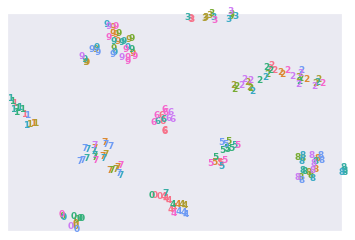

<Figure size 432x288 with 0 Axes>

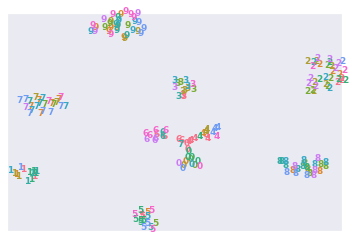

<Figure size 432x288 with 0 Axes>

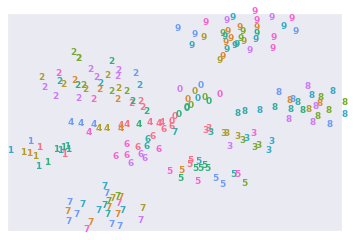

<Figure size 432x288 with 0 Axes>

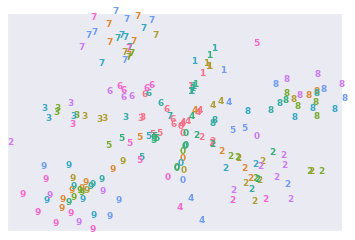

<Figure size 432x288 with 0 Axes>

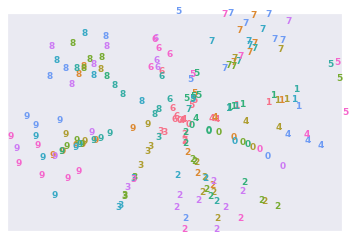

<Figure size 432x288 with 0 Axes>

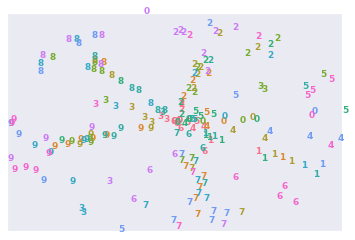

In [59]:
logdir = '/u/faghri/dmom/code/runs/mnist/bgluster,epoch_10/'
X, y, c, G_svd = get_embedding(logdir)
G_tsne = plot_tsne(X, y, c, G_svd, [2, 5, 30, 50, 70, 100])

Total loss: 0.0195
Total dist: 6.7118

Cluster 0, size: 6759
Cluster 0, loss: 0.0002
Cluster 3, size: 1098
Cluster 3, loss: 0.0004
Cluster 1, size: 467
Cluster 1, loss: 0.0024
Cluster 7, size: 145
Cluster 7, loss: 0.0174
Cluster 8, size: 303
Cluster 8, loss: 0.0237
Cluster 4, size: 840
Cluster 4, loss: 0.0410
Cluster 2, size: 106
Cluster 2, loss: 0.2152
Cluster 9, size: 99
Cluster 9, loss: 0.2898
Cluster 6, size: 86
Cluster 6, loss: 0.3783
Cluster 5, size: 97
Cluster 5, loss: 0.6657
torch.Size([200, 2265602])
> SVD
(200, 50)


<Figure size 432x288 with 0 Axes>

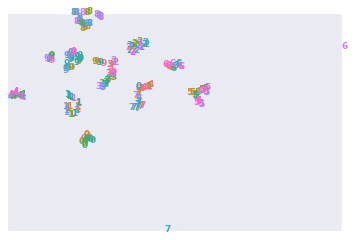

<Figure size 432x288 with 0 Axes>

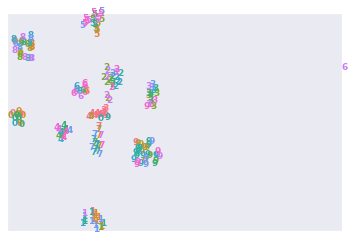

<Figure size 432x288 with 0 Axes>

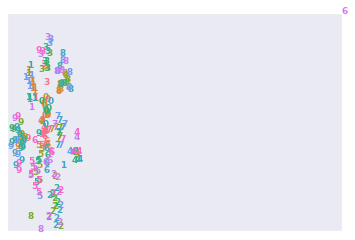

<Figure size 432x288 with 0 Axes>

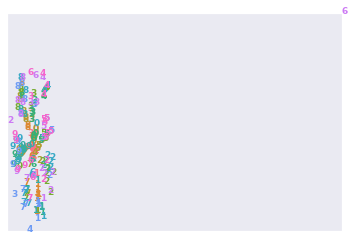

<Figure size 432x288 with 0 Axes>

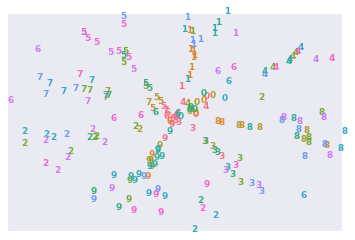

<Figure size 432x288 with 0 Axes>

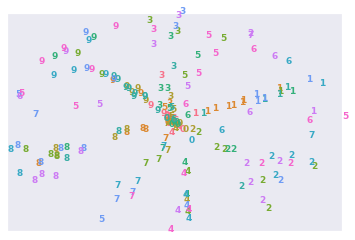

In [60]:
logdir = '/u/faghri/dmom/code/runs/mnist/bgluster,epoch_30/'
X, y, c, G_svd = get_embedding(logdir)
G_tsne = plot_tsne(X, y, c, G_svd, [2, 5, 30, 50, 70, 100])

Total loss: 0.0195
Total dist: 6.7118

Cluster 0, size: 6759
Cluster 0, loss: 0.0002
Cluster 3, size: 1098
Cluster 3, loss: 0.0004
Cluster 1, size: 467
Cluster 1, loss: 0.0024
Cluster 7, size: 145
Cluster 7, loss: 0.0174
Cluster 8, size: 303
Cluster 8, loss: 0.0237
Cluster 4, size: 840
Cluster 4, loss: 0.0410
Cluster 2, size: 106
Cluster 2, loss: 0.2152
Cluster 9, size: 99
Cluster 9, loss: 0.2898
Cluster 6, size: 86
Cluster 6, loss: 0.3783
Cluster 5, size: 97
Cluster 5, loss: 0.6657
torch.Size([982, 2265602])
> SVD
(982, 100)


<Figure size 432x288 with 0 Axes>

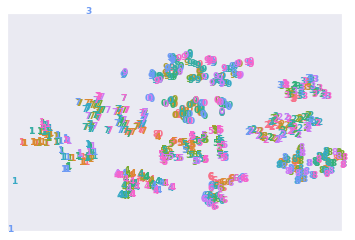

<Figure size 432x288 with 0 Axes>

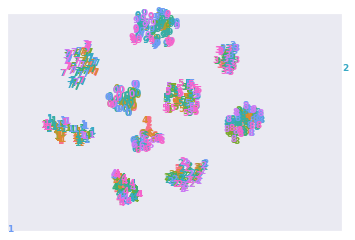

<Figure size 432x288 with 0 Axes>

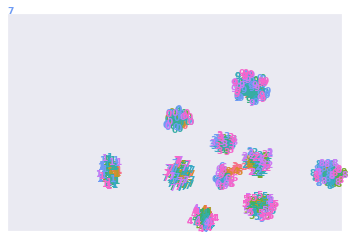

<Figure size 432x288 with 0 Axes>

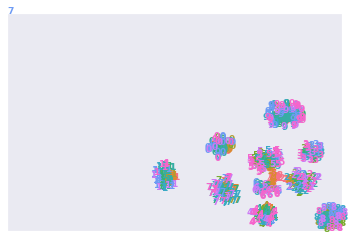

<Figure size 432x288 with 0 Axes>

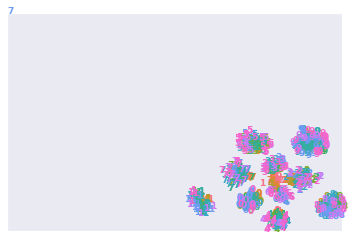

<Figure size 432x288 with 0 Axes>

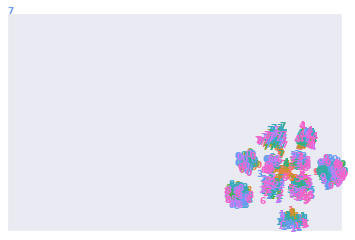

In [64]:
logdir = '/u/faghri/dmom/code/runs/mnist/bgluster,epoch_30/'
X, y, c, G_svd = get_embedding(logdir, k=100, nsamples=100)
G_tsne = plot_tsne(X, y, c, G_svd, [2, 5, 30, 50, 70, 100])

# svd

Total loss: 0.1359
Total dist: 174.8723

Cluster 1, size: 3185
Cluster 1, loss: 0.0017
Cluster 4, size: 1352
Cluster 4, loss: 0.0097
Cluster 7, size: 1016
Cluster 7, loss: 0.0145
Cluster 3, size: 867
Cluster 3, loss: 0.0324
Cluster 2, size: 832
Cluster 2, loss: 0.0370
Cluster 0, size: 601
Cluster 0, loss: 0.1126
Cluster 8, size: 965
Cluster 8, loss: 0.2116
Cluster 6, size: 383
Cluster 6, loss: 0.8183
Cluster 5, size: 394
Cluster 5, loss: 0.8374
Cluster 9, size: 405
Cluster 9, loss: 0.8673
torch.Size([200, 2265602])
> SVD
(200, 2)


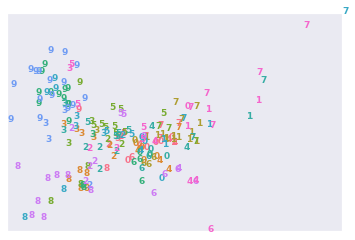

In [55]:
logdir = '/u/faghri/dmom/code/runs/mnist/bgluster,epoch_1/'
X, y, c, G_svd = get_embedding(logdir, k=2)
plot_embedding(X[:,0], G_svd, y, c)

Total loss: 0.0303
Total dist: 17.5651

Cluster 0, size: 5047
Cluster 0, loss: 0.0003
Cluster 1, size: 653
Cluster 1, loss: 0.0023
Cluster 5, size: 612
Cluster 5, loss: 0.0066
Cluster 8, size: 477
Cluster 8, loss: 0.0080
Cluster 7, size: 964
Cluster 7, loss: 0.0171
Cluster 2, size: 1534
Cluster 2, loss: 0.0234
Cluster 6, size: 243
Cluster 6, loss: 0.2243
Cluster 3, size: 151
Cluster 3, loss: 0.3261
Cluster 9, size: 157
Cluster 9, loss: 0.4150
Cluster 4, size: 162
Cluster 4, loss: 0.4384
torch.Size([200, 2265602])
> SVD
(200, 2)


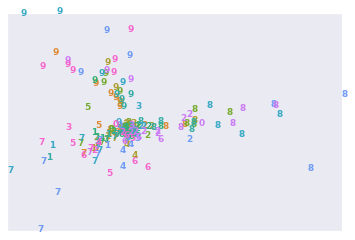

In [56]:
logdir = '/u/faghri/dmom/code/runs/mnist/bgluster,epoch_10/'
X, y, c, G_svd = get_embedding(logdir, k=2)
plot_embedding(X[:,0], G_svd, y, c)

Total loss: 0.0195
Total dist: 6.7118

Cluster 0, size: 6759
Cluster 0, loss: 0.0002
Cluster 3, size: 1098
Cluster 3, loss: 0.0004
Cluster 1, size: 467
Cluster 1, loss: 0.0024
Cluster 7, size: 145
Cluster 7, loss: 0.0174
Cluster 8, size: 303
Cluster 8, loss: 0.0237
Cluster 4, size: 840
Cluster 4, loss: 0.0410
Cluster 2, size: 106
Cluster 2, loss: 0.2152
Cluster 9, size: 99
Cluster 9, loss: 0.2898
Cluster 6, size: 86
Cluster 6, loss: 0.3783
Cluster 5, size: 97
Cluster 5, loss: 0.6657
torch.Size([200, 2265602])
> SVD
(200, 2)


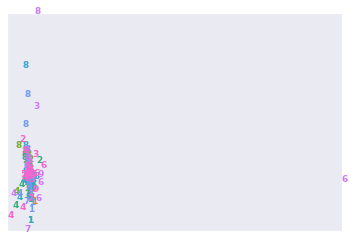

In [57]:
logdir = '/u/faghri/dmom/code/runs/mnist/bgluster,epoch_30/'
X, y, c, G_svd = get_embedding(logdir, k=2)
plot_embedding(X[:,0], G_svd, y, c)